# DQN (test)

## Setup

In [1]:
import config
import gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

from animations import *
from dqn import DQN
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
tf.version: 1.11.0


## Look at our env

In [2]:
env = gym.make(config.GAME_NAME)
env.reset()
env.render()
print(f'Game: {config.GAME_NAME}')
print(f'action_size: {env.action_space.n}')

Game: Pong-v0
action_size: 6


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 6
0: NOOP
1: FIRE
2: RIGHT
3: LEFT
4: RIGHTFIRE
5: LEFTFIRE


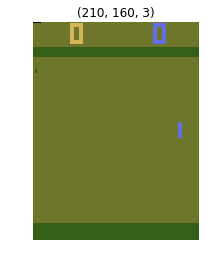

In [4]:
rgb_frame = env.reset()

plt.figure()
plt.title(f'{rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)
plt.show()

### Instantiate DQN

In [5]:
tf.reset_default_graph()

dqn = DQN(action_size=env.action_space.n, dqn_name='DQN')

### Test and watch how the agent plays Breakout-v0

In [6]:
def test(dqn, env, episode=config.NUM_EPISODES):
    frames = []
    with tf.Session() as sess:
        # load the model
        tf.train.Saver().restore(sess, config.SAVE_PATH + f'/model_episode_{episode}.ckpt')
        
        step = 0
        total_reward = 0
        done = False
        stacked_frames = []
        
        state = env.reset()
        frames.append(state)
        stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, state, 
                                                          is_new_episode=True)
        env.render()
        
        while not done:
            current_state = stacked_frames_hwc[np.newaxis,:,:,-config.STACK_SIZE:]
            Q = sess.run(dqn.output,
                         feed_dict={
                             dqn.input_ph: current_state
                         })
            
            action = np.argmax(Q)
            if np.random.rand() < 0.01:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)
            frames.append(next_state)
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
            env.render()
            
            step += 1
            total_reward += reward
            
            if step % 100 == 0:
                print(f'step: {step}, action: {action}')
        
        print(f'Steps: {step}, total_reward: {total_reward}')
    return episode, total_reward, frames

In [7]:
%%time
episode, reward, frames = test(dqn, env, episode=1)
frames = np.array(frames)

INFO:tensorflow:Restoring parameters from ./checkpoints/model_episode_1.ckpt
step: 100, action: 0
step: 200, action: 0
step: 300, action: 5
step: 400, action: 0
step: 500, action: 0
step: 600, action: 0
step: 700, action: 0
step: 800, action: 0
step: 900, action: 0
step: 1000, action: 0
Steps: 1007, total_reward: -21.0
CPU times: user 8.34 s, sys: 8.39 s, total: 16.7 s
Wall time: 6.06 s


CPU times: user 2 s, sys: 164 ms, total: 2.16 s
Wall time: 15.2 s


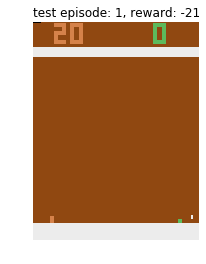

In [8]:
%%time
save_ani(episode, int(reward), frames, fps=15, skip_frames=2, 
         out_path=f'./animations/{config.GAME_NAME}/', mode='test')

In [9]:
#env.close()